In [54]:
import argparse
import cv2  # pip install opencv-python
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import defaultdict

In [55]:
def find_hough_circles(image, edge_image, r_min, r_max, delta_r, num_thetas, bin_threshold, post_process = True):
  #image size
  img_height, img_width = edge_image.shape[:2]
  
  # R and Theta ranges
  dtheta = int(360 / num_thetas)
  
  ## Thetas is bins created from 0 to 360 degree with increment of the dtheta
  thetas = np.arange(0, 360, step=dtheta)
  
  ## Radius ranges from r_min to r_max 
  rs = np.arange(r_min, r_max, step=delta_r)
  
  # Calculate Cos(theta) and Sin(theta) it will be required later
  cos_thetas = np.cos(np.deg2rad(thetas))
  sin_thetas = np.sin(np.deg2rad(thetas))
  
  # Evaluate and keep ready the candidate circles dx and dy for different delta radius
  # based on the the parametric equation of circle.
  # x = x_center + r * cos(t) and y = y_center + r * sin(t),  
  # where (x_center,y_center) is Center of candidate circle with radius r. t in range of [0,2PI)
  circle_candidates = []
  for r in rs:
    for t in range(num_thetas):
      #instead of using pre-calculated cos and sin theta values you can calculate here itself by following
      #circle_candidates.append((r, int(r*cos(2*pi*t/num_thetas)), int(r*sin(2*pi*t/num_thetas))))
      #but its better to pre-calculate and use it here.
      circle_candidates.append((r, int(r * cos_thetas[t]), int(r * sin_thetas[t])))
  
  # Hough Accumulator, we are using defaultdic instead of standard dict as this will initialize for key which is not 
  # aready present in the dictionary instead of throwing exception.
  accumulator = defaultdict(int)
  
  for y in range(img_height):
    for x in range(img_width):
      if edge_image[y][x] != 0: #white pixel
        # Found an edge pixel so now find and vote for circle from the candidate circles passing through this pixel.
        for r, rcos_t, rsin_t in circle_candidates:
          x_center = x - rcos_t
          y_center = y - rsin_t
          accumulator[(x_center, y_center, r)] += 1 #vote for current candidate
  
  # Output image with detected lines drawn
  output_img = image.copy()
  # Output list of detected circles. A single circle would be a tuple of (x,y,r,threshold) 
  out_circles = []
  
  # Sort the accumulator based on the votes for the candidate circles 
  for candidate_circle, votes in sorted(accumulator.items(), key=lambda i: -i[1]):
    x, y, r = candidate_circle
    current_vote_percentage = votes / num_thetas
    if current_vote_percentage >= bin_threshold: 
      # Shortlist the circle for final result
      out_circles.append((x, y, r, current_vote_percentage))
      print(x, y, r, current_vote_percentage)
      
  
  # Post process the results, can add more post processing later.
  if post_process :
    pixel_threshold = 5
    postprocess_circles = []
    for x, y, r, v in out_circles:
      # Exclude circles that are too close of each other
      # all((x - xc) ** 2 + (y - yc) ** 2 > rc ** 2 for xc, yc, rc, v in postprocess_circles)
      # Remove nearby duplicate circles based on pixel_threshold
      if all(abs(x - xc) > pixel_threshold or abs(y - yc) > pixel_threshold or abs(r - rc) > pixel_threshold for xc, yc, rc, v in postprocess_circles):
        postprocess_circles.append((x, y, r, v))
    out_circles = postprocess_circles
  
    
  # Draw shortlisted circles on the output image
  for x, y, r, v in out_circles:
    output_img = cv2.circle(output_img, (x,y), r, (0,255,0), 2)
  
  return output_img, out_circles

In [56]:
img_path = "ex2.png"       # Full path of the input image
r_min = 10                         # Min radius circle to detect.
r_max = 50                         # Max radius circle to detect.
delta_r = 1                         # Delta change in radius from r_min to r_max.
num_thetas = 100                    # Number of steps for theta from 0 to 2PI.
bin_threshold = 0.4                 # Thresholding value to shortlist candidate for circle. Default is 0.4 i.e. 40%.
min_edge_threshold = 350            # Minimum threshold value for edge detection.
max_edge_threshold = 400            # Maximum threshold value for edge detection.

input_img = cv2.imread(img_path, cv2.IMREAD_COLOR)
image_rgb = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)

#Edge detection on the input image
input_img_gray = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2GRAY)

#ret, edge_image = cv2.threshold(edge_image, 120, 255, cv2.THRESH_BINARY_INV)
edge_detected = cv2.Canny(input_img_gray, min_edge_threshold, max_edge_threshold)

circle_img, circles = find_hough_circles(input_img, edge_detected, r_min, r_max, delta_r, num_thetas, bin_threshold)
circle_img_rgb = cv2.cvtColor(circle_img, cv2.COLOR_BGR2RGB)

85 72 22 0.55
279 71 23 0.47
279 72 22 0.45
85 71 23 0.44
85 73 22 0.43
278 74 20 0.4
84 73 21 0.4
85 73 21 0.4


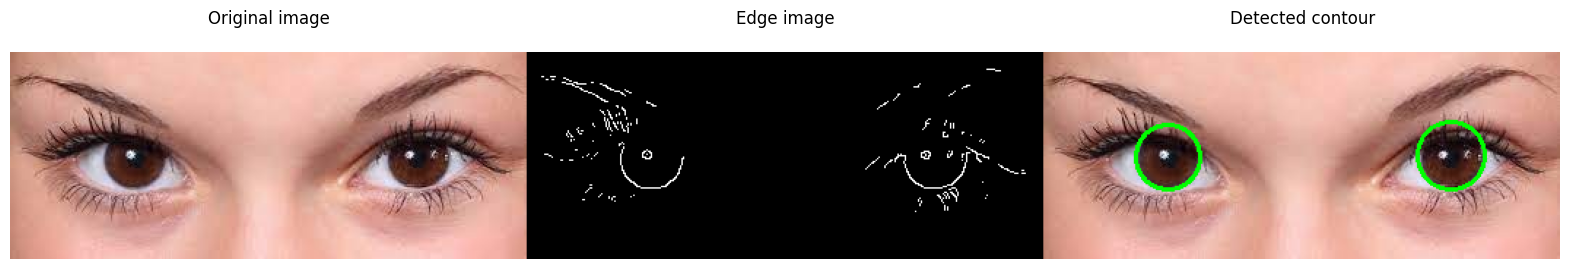

In [57]:
edges_expanded = np.repeat(edge_detected[:,:,np.newaxis], 3, axis=2)
concatenated_image = np.concatenate((image_rgb, edges_expanded, circle_img_rgb), axis=1)
fig, ax = plt.subplots(figsize=(20, 15))

plt.imshow(concatenated_image, cmap='gray')
plt.axis('off')
ax.text(0.5 * image_rgb.shape[1], -20, 'Original image', fontsize=12, color='black', ha='center')
ax.text(image_rgb.shape[1] + 0.5 * edge_detected.shape[1], -20, 'Edge image', fontsize=12, color='black', ha='center')
ax.text(image_rgb.shape[1] + edges_expanded.shape[1] + 0.5 * circle_img_rgb.shape[1], -20, 'Detected contour', fontsize=12, color='black', ha='center')
plt.show()